In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import time
import json
import sys

sys.path.append("../")

In [151]:
image = np.random.randint(0, 255, (224, 224, 3)).astype(np.uint8)

In [152]:
from model_server.prediction.rest import RESTAPIPrediction
from model_server.prediction.grpc import GRPCPredictionAPI
from model_server.model_server_config import TensorFlowServingModelConfig
from model_server.management import GRPCModelServiceAPI

The model config file for TensorFlow Serving can be configured on the fly to load and unload models where necessary.

In [153]:
model_config = TensorFlowServingModelConfig()
model_management = GRPCModelServiceAPI()
model_config.initialise_blank_config()
model_config.add_model(model_name="7EB5B", base_path="/models/7EB5B/")
model_config.add_model(model_name="B04A8", base_path="/models/B04A8/")
model_config.save_protobuf("../models/build/model_config.proto")
model_management.replace_server_config(model_config.to_proto())

Separate classes are available to interact with the server via either the RESTful API or the gRPC API.

In [66]:
rest_server = RESTAPIPrediction()

In [69]:
rest_timings = []
for _ in range(1_000):
    s = time.perf_counter()
    prediction = rest_server.get_prediction(
        model_name="B04A8", model_version=1, inputs=image
    )
    e = time.perf_counter()
    rest_timings.append(e - s)

In [72]:
grpc_server = GRPCPredictionAPI()

In [73]:
grpc_timings = []
for _ in range(1_000):
    s = time.perf_counter()
    prediction = grpc_server.get_prediction(
        model_name="7EB5B",
        model_version=1,
        inputs=image,
        input_layer_name="input_8",
        output_layer_name="fc1000",
    )
    e = time.perf_counter()
    grpc_timings.append(e - s)

In [94]:
timings = pd.DataFrame({"rest": rest_timings, "grpc": grpc_timings})
timings = timings * 1000

Text(0,0.5,'Response time (milliseconds)')

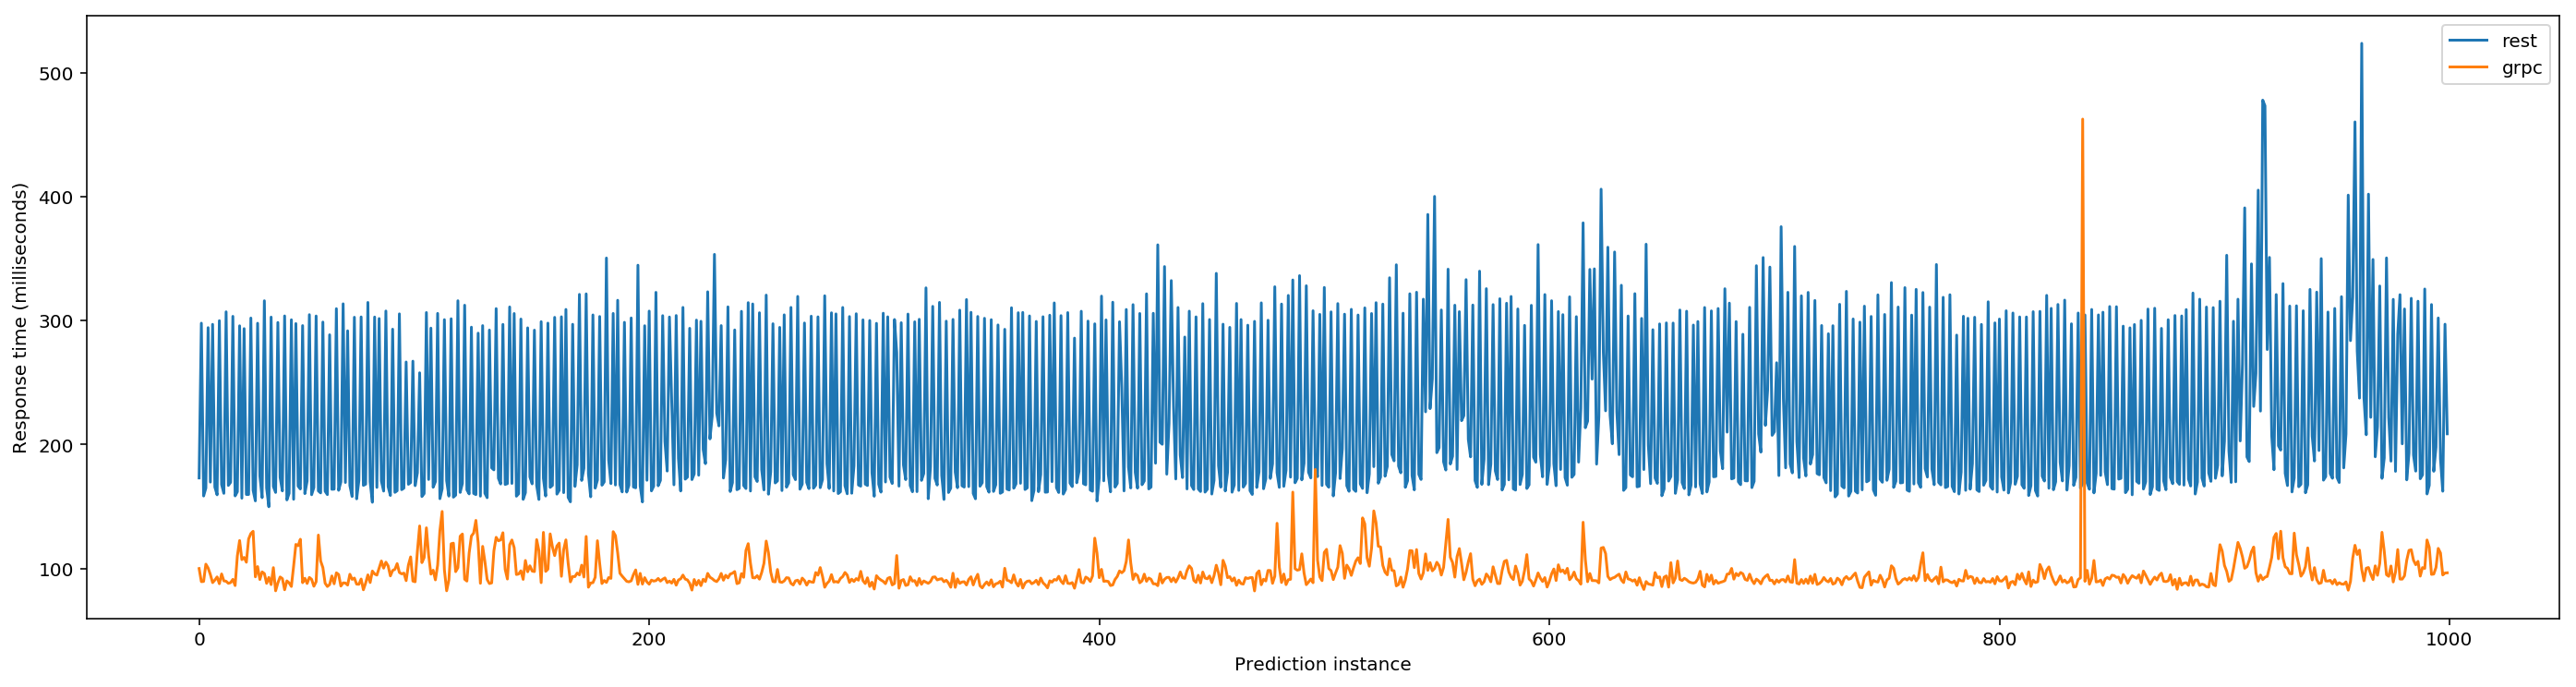

In [96]:
f, ax = plt.subplots(1, figsize=(24, 6))
sns.lineplot(data=timings, dashes=False, ax=ax)
ax.set_xlabel("Prediction instance")
ax.set_ylabel("Response time (milliseconds)")

Text(0,0.5,'Response time (milliseconds)')

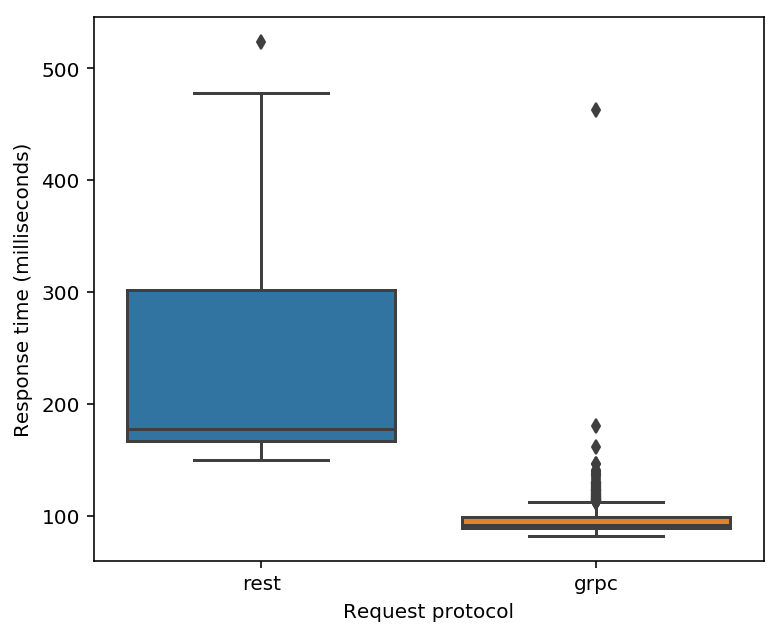

In [97]:
f, ax = plt.subplots(1, figsize=(6, 5))
sns.boxplot(data=timings, ax=ax)
ax.set_xlabel("Request protocol")
ax.set_ylabel("Response time (milliseconds)")

In [98]:
timings.describe()

,rest,grpc
count,1000.000000,1000.000000
mean,223.746716,96.318856
std,70.524178,16.003708
min,149.813042,81.928862
25%,166.518194,89.307718
50%,177.729703,92.088286
75%,302.128773,98.380713
max,523.662213,462.546966
